## Imports

In [2]:
# Numbers
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Graphs
import seaborn as sns

# ML
import sklearn
import sklearn.model_selection
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

# Pipeline
from sklearn.model_selection import train_test_split # For train/test splits
from sklearn.feature_selection import VarianceThreshold # Feature selector
from sklearn.pipeline import Pipeline # For setting up pipeline

# Various pre-processing steps
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, PowerTransformer, MaxAbsScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV # For optimization


In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

## Loading Data

In [4]:
data_train = pd.read_csv("heart_train.csv")
data_train_oh = pd.get_dummies(data_train, drop_first=True).iloc[:,2:]

data_test = pd.read_csv("heart_test.csv")
data_test_oh = pd.get_dummies(data_test, drop_first=True).iloc[:,2:]

<Axes: >

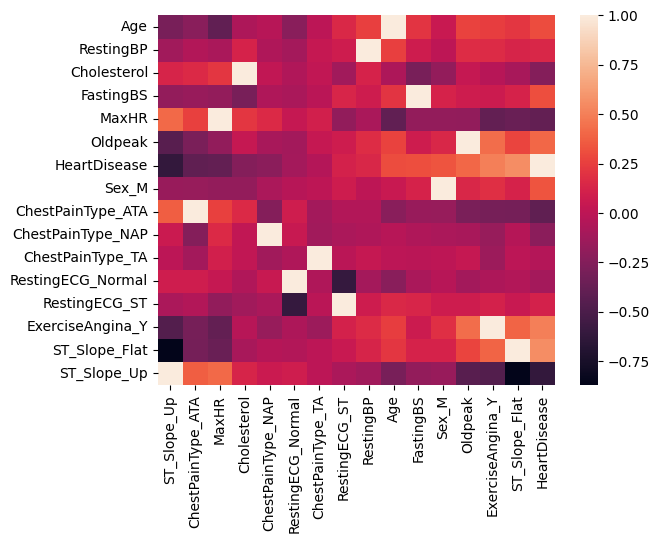

In [5]:
train_cor = data_train_oh.corr().sort_values("HeartDisease",axis = 1)
sns.heatmap(train_cor)

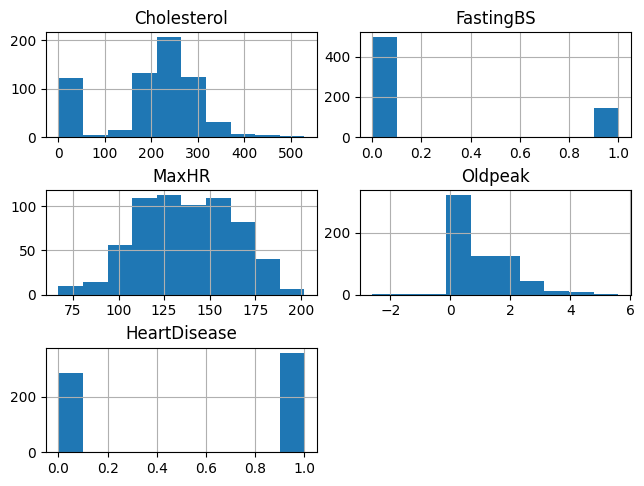

In [8]:
data_train_oh.iloc[:,2:].hist()
plt.tight_layout( pad = 0.5)

Separating X values for data_train

In [6]:
data_trainX = data_train_oh.loc[:,data_train_oh.columns != 'HeartDisease']
data_trainX

data_testX = data_test_oh.loc[:,data_test_oh.columns != 'HeartDisease']
data_testX

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,69,122,216,1,84,0.0,True,False,False,False,False,False,True,True,False
1,74,145,216,1,116,1.8,True,False,False,True,True,False,True,True,False
2,66,146,278,0,152,0.0,False,False,True,False,False,False,False,True,False
3,53,144,300,1,128,1.5,True,False,False,False,False,True,True,True,False
4,41,105,198,0,168,0.0,False,True,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,60,150,258,0,157,2.6,False,False,False,False,False,False,False,True,False
271,58,132,224,0,173,3.2,True,False,True,False,False,False,False,False,True
272,62,139,170,0,120,3.0,True,False,False,False,False,True,True,True,False
273,55,135,204,1,126,1.1,True,False,False,False,False,True,True,True,False


Separating Y values for data_test

In [7]:
data_trainY = data_train["HeartDisease"]
data_trainY

0      0
1      1
2      0
3      1
4      0
      ..
638    1
639    1
640    1
641    1
642    0
Name: HeartDisease, Length: 643, dtype: int64

## Pipeline AdaBoost

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    data_trainX,
    data_trainY,
    test_size=0.25,
    random_state=0)

print(X_train.shape)
print(X_test.shape)

(482, 15)
(161, 15)


In [9]:
pipe = \
Pipeline(steps=[('scaler', MinMaxScaler()),
('selector',  SelectFromModel(LinearSVC(C=0.1, penalty="l1", dual=False))),
('classifier', AdaBoostClassifier(\
                                  estimator = DecisionTreeClassifier(max_depth=1), \
                                  algorithm = 'SAMME', random_state=0))])

pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)

print('Training set score: ' + str(pipe.score(X_train,y_train)))
print('Test set score: ' + str(pipe.score(X_test,y_test)))
print()
print("Accuracy on test data:", accuracy_score(y_test, y_pred))
print("Balanced accuracy on test data:", balanced_accuracy_score(y_test, y_pred))

Training set score: 0.8692946058091287
Test set score: 0.8819875776397516

Accuracy on test data: 0.8819875776397516
Balanced accuracy on test data: 0.8818604651162791


In [10]:
parameters = {'scaler': [StandardScaler(), MinMaxScaler(),
              Normalizer(), MaxAbsScaler()],
              'classifier__estimator__max_depth' :[i for i in range(2,11,2)],
              'classifier__estimator__min_samples_leaf' : [i for i in range(5,10)],
              'classifier__n_estimators': [x for x in range(1,30,2)],
              'classifier__learning_rate': [(0.97 + x / 100) for x in range(0, 8)],
              }

In [11]:
grid = GridSearchCV(pipe, parameters, cv=2).fit(X_train, y_train)

y_pred = grid.predict(X_test)

print('Training set score: ' + str(grid.score(X_train, y_train)))
print('Test set score: ' + str(grid.score(X_test, y_test)))
print()
print("Accuracy on test data:", accuracy_score(y_test, y_pred))
print("Balanced accuracy on test data:", balanced_accuracy_score(y_test, y_pred))

Training set score: 0.8900414937759336
Test set score: 0.8944099378881988

Accuracy on test data: 0.8944099378881988
Balanced accuracy on test data: 0.8943410852713178


In [12]:
# Access the best set of parameters
best_params = grid.best_params_
print(best_params)
# Stores the optimum model in best_pipe
best_pipe = grid.best_estimator_
print(best_pipe)

{'classifier__estimator__max_depth': 2, 'classifier__estimator__min_samples_leaf': 5, 'classifier__learning_rate': 0.98, 'classifier__n_estimators': 23, 'scaler': MaxAbsScaler()}
Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('selector',
                 SelectFromModel(estimator=LinearSVC(C=0.1, dual=False,
                                                     penalty='l1'))),
                ('classifier',
                 AdaBoostClassifier(algorithm='SAMME',
                                    estimator=DecisionTreeClassifier(max_depth=2,
                                                                     min_samples_leaf=5),
                                    learning_rate=0.98, n_estimators=23,
                                    random_state=0))])


### Test/Export

In [13]:
Y_pred_test = pipe.predict(data_testX)

In [14]:
Y_pred_test

array([1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1])

In [15]:
return_dataset = pd.DataFrame({'id': data_test['id'], 'output': Y_pred_test})
return_dataset

,id,output
0,643,1
1,644,1
2,645,0
3,646,1
4,647,0
...,...,...
270,913,1
271,914,0
272,915,1
273,916,1


In [16]:
return_dataset['output'].value_counts(True)

output
1    0.56
0    0.44
Name: proportion, dtype: float64

In [17]:
return_dataset.to_csv("heart_test.csv", index = False)

## Pipeline DecisionTreeClassifier

In [18]:
pipe = \
Pipeline(steps=[('scaler', MinMaxScaler()),
('selector',  SelectFromModel(LinearSVC(C=0.1, penalty="l1", dual=False))),
('classifier', DecisionTreeClassifier(max_depth=5,criterion='entropy'))])


pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)

print('Training set score: ' + str(pipe.score(X_train,y_train)))
print('Test set score: ' + str(pipe.score(X_test,y_test)))

print()
print("Accuracy on test data:", accuracy_score(y_test, y_pred))
print("Ballanced accuracy on test data:", balanced_accuracy_score(y_test, y_pred))

Training set score: 0.8858921161825726
Test set score: 0.8944099378881988

Accuracy on test data: 0.8944099378881988
Ballanced accuracy on test data: 0.8926356589147286


# Optimization

In [19]:
parameters = {'scaler': [StandardScaler(), MinMaxScaler(),
              Normalizer(), MaxAbsScaler()]
              }

In [20]:
grid = GridSearchCV(pipe, parameters, cv=2).fit(X_train, y_train)

y_pred = grid.predict(X_test)

print('Training set score: ' + str(grid.score(X_train, y_train)))
print('Test set score: ' + str(grid.score(X_test, y_test)))
print()
print("Accuracy on test data:", accuracy_score(y_test, y_pred))
print("Ballanced accuracy on test data:", balanced_accuracy_score(y_test, y_pred))

Training set score: 0.8858921161825726
Test set score: 0.8881987577639752

Accuracy on test data: 0.8881987577639752
Ballanced accuracy on test data: 0.8868217054263565


In [21]:
grid = GridSearchCV(pipe, parameters, cv=2).fit(X_train, y_train)

y_pred = grid.predict(X_test)

print('Training set score: ' + str(grid.score(X_train, y_train)))
print('Test set score: ' + str(grid.score(X_test, y_test)))
print()
print("Accuracy on test data:", accuracy_score(y_test, y_pred))
print("Ballanced accuracy on test data:", balanced_accuracy_score(y_test, y_pred))

Training set score: 0.8858921161825726
Test set score: 0.8881987577639752

Accuracy on test data: 0.8881987577639752
Ballanced accuracy on test data: 0.8868217054263565


In [22]:
# Access the best set of parameters
best_params = grid.best_params_
print(best_params)
# Stores the optimum model in best_pipe
best_pipe = grid.best_estimator_
print(best_pipe)

{'scaler': MinMaxScaler()}
Pipeline(steps=[('scaler', MinMaxScaler()),
                ('selector',
                 SelectFromModel(estimator=LinearSVC(C=0.1, dual=False,
                                                     penalty='l1'))),
                ('classifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=5))])


In [32]:
result_df = pd.DataFrame.from_dict(grid.cv_results_, orient='columns')

sns.relplot(data=result_df,
 kind='line',
 x='param_classifier__n_neighbour',
 y='mean_test_score',
 hue='param_scaler',
 col='param_classifier__p')
plt.show()

"\nsns.relplot(data=result_df,\n kind='line',\n x='param_classifier__n_neighbour',\n y='mean_test_score',\n hue='param_scaler',\n col='param_classifier__p')\nplt.show()\n"

## Pipeline XG Boost

In [30]:
pipe = \
Pipeline(steps=[('scaler', StandardScaler()),
('selector',  SelectFromModel(XGBClassifier())),
('classifier', XGBClassifier())])

pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)

print('Training set score: ' + str(pipe.score(X_train,y_train)))
print('Test set score: ' + str(pipe.score(X_test,y_test)))

print()
print("Accuracy on test data:", accuracy_score(y_test, y_pred))
print("Ballanced accuracy on test data:", balanced_accuracy_score(y_test, y_pred))

Training set score: 0.8091286307053942
Test set score: 0.8260869565217391

Accuracy on test data: 0.8260869565217391
Ballanced accuracy on test data: 0.8252713178294574


### Generating predictions

### Saving predictions to CSV